# MBAI 448 | Week 2 Walkthrough: Image Embeddings as Representations

##### Walkthrough Overview

This walkthrough explores how data representations can be applied to a real-world problem. It is organized into three Acts:

- Act I: Understand the problem and context
- Act II: Prototype a solution with AI technology
- Act III: Socialize the work with stakeholders

##### Assignment Tools

This assignment assumes you will be working with Github Copilot in VS Code, and will require you to submit your chat history along with this notebook. If you are curious about how to work effectively with Github Copilot, please consult the [VS Code documentation](https://code.visualstudio.com/docs/copilot/overview).

Submissions that demonstrate thoughtless interaction with Copilot (e.g., asking Copilot to just read the notebook and produce all the outputs) will receive reduced credit.

### Act 1 : Understand the problem and context

##### Business Goal / Case Statement
Attract more customers by enhancing menu search.

##### Assignment Context

**Relevant Industry and/or Business Function:** Foodservice / Restaurant

**Description:** You report to a new franchisee of the popular resturant chain Ordos Foods.  They have a large menu and believe that could be an asset for them, but data from third-party delivery partners suggest customers have a hard time finding the meal they want. You have been asked to demonstrate a capability that would allow customers to better find what they want by searching with images or product descriptions.

##### The Data

**Dataset Name:** <code>[chinese-food-caption](https://huggingface.co/datasets/zmao/chinese_food_caption)</code><br>
**Data Location:** <code>https://huggingface.co/datasets/zmao/chinese_food_caption</code>

#### Step 0 : Scope the work in `agents.md`

Before moving forward, create a a file named `agents.md` in the project root directory (likely the same level of the directory in which this notebook lives). This file specifies the intended role of AI in this project and serves as reference context for Github Copilot as you work.

Your `agents.md` must include the following five sections:

##### 1. What we’re building
A one-sentence "elevator pitch" describing the prototype and its primary output (e.g., "A predictive lead-scoring engine that identifies high-value customers based on historical CRM data.")

##### 2. How AI helps solve the business problem
2–4 bullet points explaining the specific value-add of the AI components. Focus on the transition from the business "pain point" to the AI "solution."

##### 3. Key file locations and data structure
List the paths that matter (e.g., `notebooks/exploration.ipynb`, `data/raw_leads.csv`).

##### 4. High-level execution plan
A step-by-step outline of the build process (e.g., 1. Data cleaning, 2. Feature engineering, 3. Model training, 4. Visualization of results). Feel free to ask Copilot for help (or take a peek at the steps in Act II below) for a sense on structuring the work.

##### 5. Code conventions and constraints
To ensure the prototype remains manageable, add 1-2 bullet points specifying that code be as simple and straightforward, using standard libraries unless instructed otherwise.

### Act 2 : Prototype a solution with AI technology

## Prototyping an Encoder-Based Search System

In this act, you will prototype an encoder-based search system that compares items based on learned representations rather than exact matches.

This is an exploratory prototype. The goal is to understand how encoder-based representations behave in practice: how similarity emerges, what those similarities capture, and where they fail to align with the problem you are trying to solve.

You are encouraged to use GitHub Copilot throughout. For each step, follow the same disciplined loop:

- **Plan**: Have Copilot create a short, narrative plan describing what needs to happen and what artifacts will be produced.
- **Validate**: Review and revise that plan until it is complete, coherent, and aligned with the purpose of the step.
- **Execute**: Once the plan is validated, have Copilot implement it in code.
- **Check**: Use the resulting code to perform one or two concrete actions that confirm you have what you need.

#### Environment Setup

To run this notebook locally as you move through the assignment, we suggest you create and activate a Python virtual environment.

From the project root directory:

##### On MacOS/Linux:
`python -m venv venv
`source venv/bin/activate

##### On Windows:
`python -m venv venv
`venv\Scripts\activate

Once your virtual environment is activated, you can set it as the kernel for this notebook in the top right corner of your notebook pane.


## Step 1: Load the dataset and make the items explicit

Before introducing representations, you need a concrete understanding of what the system will operate over.

### Plan
Have Copilot create a plan to:
- load the dataset
- determine how many items it contains
- identify what constitutes a single searchable item
- display several example items with their available attributes

### Validate
Ensure the plan:
- downloads only a portion of the data, so it's easier to work with (NOTE: the walkthrough data are small, so we download the whole thing)
- makes no assumptions about embeddings or similarity
- clearly distinguishes raw items from any derived representations

### Execute
Once the plan is validated, have Copilot implement it in code.

### Check
- Print the total number of items in the dataset.
- Display at least three example items, including all available fields.

Food for thought:
- What information from these images do you think is important for your task? 
- How effective would traditional text keyword search be here? With the data as-is, could you implement sorting and filtering?

In [1]:
# write Step 1 code below

%pip install --quiet "datasets<4.0.0" pillow

from datasets import load_dataset

data = load_dataset("zmao/chinese_food_caption", split="train")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
from PIL import Image

def sample_data(dataset_object, show_embeddings=False):
    i = random.randint(0, dataset_object.shape[0]-1)
    if show_embeddings:
        print("\033[1mText caption embedding:\033[0m <shape ({},1)>".format(len(dataset_object[i]['text_embedding'])))
        print(dataset_object[i]['text_embedding'])
    print('"' + dataset_object[i]['text'] + '"')
    if show_embeddings:
        print("\n\033[1mImage embedding:\033[0m <shape ({},1)>".format(len(dataset_object[i]['image_embedding'])))
        print(dataset_object[i]['image_embedding'])
    display(dataset_object[i]['image'])
    return dataset_object[i]['image']

In [3]:
# check Step 1 below 

data.shape

(720, 2)

"s/steamed sea bass with shredded pork"


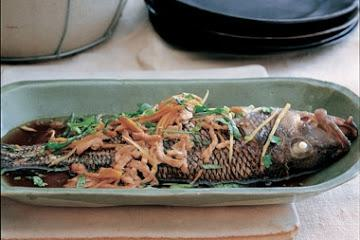

In [4]:
example = sample_data(data)

"s/mushrooms and tofu with chinese mustard greens"


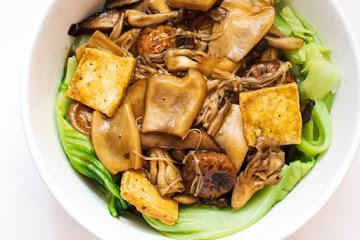

In [5]:
example_2 = sample_data(data)

"s/dan dan mian noodles in spicy chinese peanut pork sauce"


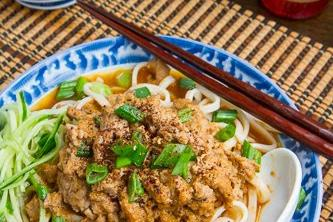

In [6]:
example_3 = sample_data(data)

## Step 2: Generate embeddings using a pretrained encoder

This step introduces the representation that will later support similarity-based comparison.

### Plan
Have Copilot create a plan to:
- select an appropriate pretrained encoder for the item content (https://huggingface.co/openai/clip-vit-base-patch16 should work)
- apply any required preprocessing
- convert each item into a fixed-length embedding
- store embeddings in a structure suitable for comparison

### Validate
Ensure the plan:
- uses the pretrained model as-is (no training or fine-tuning)
- applies preprocessing consistently across all items
- creates embeddings for the images and also creates embeddings for their captions

### Execute
Once the plan is validated, have Copilot implement it in code.

### Check
- Print the shape and datatype of the embedding collection.
- Inspect a small slice of one embedding (e.g., the first few values).
- Confirm that embeddings are populated (not all zeros or NaNs).

Food for thought:
- If you swapped in a different encoder, what might change even if the input data stayed the same?

In [7]:
# write Step 2 code below

%pip install --quiet transformers sentencepiece torch faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# because numpy was throwing compatibility warnings
%pip install -U "numpy<2"

In [ ]:
# write Step 2 code below

# load libraries
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import torch
import numpy as np
import faiss

# instantiate  
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
pretrained_model = "openai/clip-vit-base-patch16"
model = AutoModel.from_pretrained(pretrained_model, use_safetensors=True).to(device)
processor = AutoImageProcessor.from_pretrained(pretrained_model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
# functions to create embeddings for one datum
def get_photo_embedding(photo):
    inputs = processor([photo], return_tensors="pt")
    inputs = {k: v.to("cpu") for k, v in inputs.items()}
    feats = model.get_image_features(**inputs)
    return feats[0].detach().cpu().numpy()

def get_caption_embedding(caption):
    inputs = tokenizer([caption], return_tensors="pt")
    inputs = {k: v.to("cpu") for k, v in inputs.items()}
    feats = model.get_text_features(**inputs)
    return feats[0].detach().cpu().numpy()

In [14]:
# create embeddings for all the data
data = data.map(lambda cell: {'text_embedding': get_caption_embedding(cell['text'])})

data = data.map(lambda cell: {'image_embedding': get_photo_embedding(cell['image'])})

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [15]:
# check Step 2 code below

data.add_faiss_index(column='text_embedding')

data.add_faiss_index(column='image_embedding')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'image', 'text_embedding', 'image_embedding'],
    num_rows: 720
})

Text caption embedding: <shape (512,1)>
[0.4244770407676697, -0.1736651062965393, -0.18863564729690552, 0.08268602192401886, 0.14241644740104675, 0.08303044736385345, -0.23582538962364197, -0.11555108428001404, -0.20973482728004456, -0.008746422827243805, 0.62432861328125, -0.1860082596540451, 0.12537989020347595, -0.06231193244457245, 0.34038054943084717, -0.22445164620876312, -0.1339796483516693, 0.21521292626857758, 0.09194094687700272, -0.22863918542861938, -0.10616087913513184, -0.08052670955657959, -0.41228926181793213, -0.4295852482318878, -0.029629766941070557, -0.003011748194694519, 0.14451688528060913, 0.061497725546360016, -0.3600671589374542, -0.3076164126396179, 0.4318923056125641, 0.10924587398767471, 0.3437424600124359, 0.0006508044898509979, 0.10079121589660645, 0.5444413423538208, -0.11567716300487518, -0.03576026111841202, -0.03341326862573624, -0.2773616909980774, 0.28219661116600037, -0.221265509724617, -0.10009164363145828, 0.48297902941703796, 0.3244888484477997, 

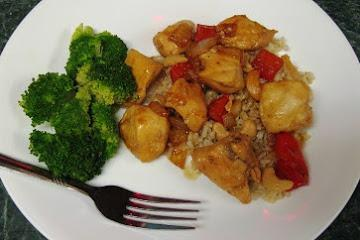

In [16]:
example_4 = sample_data(data, show_embeddings=True)

## Step 3: Compare items in representation space

Embeddings are not representations for a human audience, but a machine can use them.

### Plan
Have Copilot create a plan to:
- define a similarity or distance metric
- select a query item
- retrieve the nearest neighbors for that query
- display the query alongside retrieved items

### Validate
Ensure the plan:
- specifies the similarity metric explicitly
- allows retrieved results to be traced back to original items
- does not assume that nearest neighbors are necessarily “correct”

### Execute
Once the plan is validated, have Copilot implement it in code.

### Check
- Run the search for a specific item and display the top results. 
- If you first searched using an image, now try using a description (or vice versa).

Food for thought:
- What does “similar” appear to mean in this representation space? 
- Can you recognize commonalities in similar representations?

In [19]:
# write Step 3 code below

def print_nearest_neighbors(dataset_obj, embeddings_col, original, target, n=5):
    is_img = True
    if 'text' in embeddings_col or 'image' not in embeddings_col:
        is_img = False
    try:
        scores, examples = dataset_obj.get_nearest_examples(embeddings_col, target, k=n)
        print("\033[1mInitial target:\033[0m {}".format('text' if not is_img else 'image'))
        if is_img:
            display(original)
        else:
            print('"'+original+'"')
        print("---------------------------------------------------------------\n")
        for i in range(0,n):
            result_detail = "\033[1mRESULT {}\033[0m ({} distance)".format(i, round(float(scores[i]), ndigits=2))
            print(result_detail)
            print(examples['text'][i])
            display(examples['image'][i])
            result_footer = "." * (38+len(result_detail))
            print(result_footer)
            print('\n')
    except Exception as e:
        print('Error processing output ({}). Please confirm your inputs are valid and try again.'.format(e))

Initial target: text
"cumin lamb with hand-pulled noodles"
---------------------------------------------------------------

RESULT 0 (24.7 distance)
s/homemade knifecut noodles with simple pork chao mian


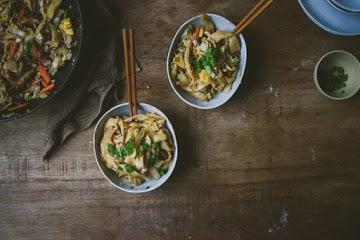

......................................................................


RESULT 1 (25.65 distance)
s/chinese wide noodles with barbecue pork and dried mushrooms


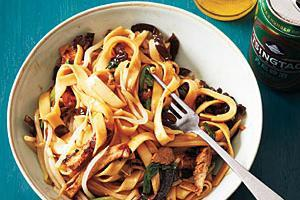

.......................................................................


RESULT 2 (27.93 distance)
s/zha jiang mian chinese braised pork and shiitake noodles with cucumber


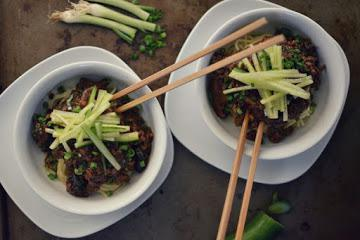

.......................................................................


RESULT 3 (27.97 distance)
s/stir fried shanghai noodles with ground pork and napa cabbage


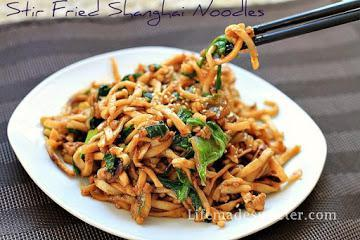

.......................................................................


RESULT 4 (28.62 distance)
s/beef and chinese cabbage with noodles


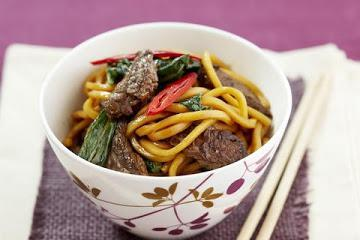

.......................................................................




In [20]:
# check Step 3 code below

caption = "cumin lamb with hand-pulled noodles"

print_nearest_neighbors(data, "text_embedding", caption, get_caption_embedding(caption), n=5)

Initial target: image


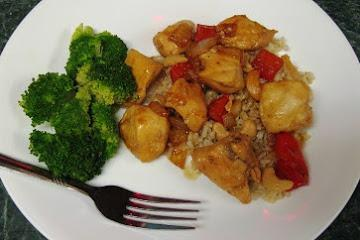

---------------------------------------------------------------

RESULT 0 (0.46 distance)
s/chinese orange barbecue cashew chicken


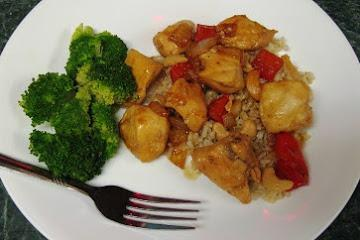

......................................................................


RESULT 1 (27.79 distance)
s/chinese hoisin chicken


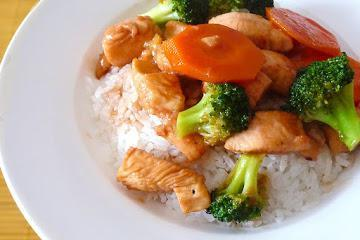

.......................................................................


RESULT 2 (33.66 distance)
s/chinese chicken and broccoli


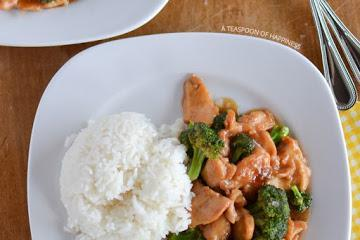

.......................................................................


RESULT 3 (34.33 distance)
s/sweet and sour chicken i


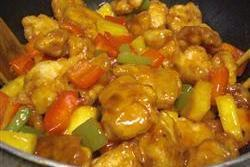

.......................................................................


RESULT 4 (34.83 distance)
s/chinese sweet and sour pork


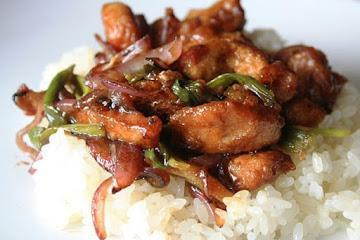

.......................................................................




In [21]:
print_nearest_neighbors(data, "image_embedding", example_4, get_photo_embedding(example_4), n=5)

## Step 4: Probe representation behavior with contrastive queries

To build your intution about how these representations function, observe how results change under controlled variation.

### Plan
Have Copilot create a plan to:
- issue two closely related queries that differ in one meaningful way (e.g., red shirt vs. blue shirt, khaki pants vs. khaki shorts, etc.)
- retrieve results for both queries
- present the results side by side for comparison

### Validate
Ensure the plan:
- keeps the embeddings and indices you built earlier unchanged
- varies only the query
- produces outputs that can be compared directly

### Execute
Once the plan is validated, have Copilot implement it in code.

### Check
- Identify at least one item that appears in one result set but not the other.
- Note what change in the query caused this shift.

Food for thought:
- What sorts of nuance does this representation seem to capture well, and what sorts of nuance does it seem to capture poorly? 
- Why do you think that is?

In [22]:
# write Step 4 code below

query_1 = "bone-in chicken with green peppercorn broth"

query_2 = "bone-in chicken with millet pepper"

Initial target: text
"bone-in chicken with green peppercorn broth"
---------------------------------------------------------------

RESULT 0 (26.61 distance)
s/chinese chicken noodle soup with sesame and green onions


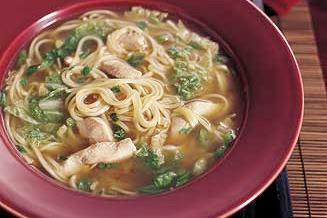

.......................................................................


RESULT 1 (30.94 distance)
s/roast chicken noodle soup with chrysanthemum


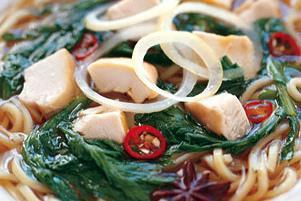

.......................................................................


RESULT 2 (31.57 distance)
s/chinese chicken and corn soup


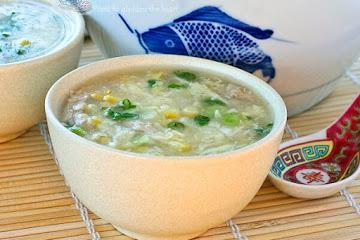

.......................................................................


RESULT 3 (31.99 distance)
s/chinese chicken and rice soup food network


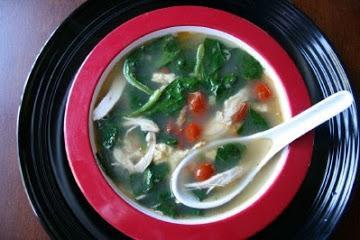

.......................................................................


RESULT 4 (32.22 distance)
s/chinese chicken  sweetcorn soup


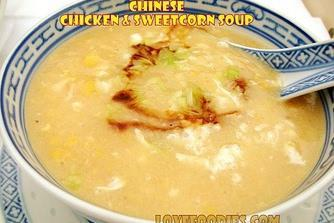

.......................................................................




In [23]:
# check Step 4 code below

print_nearest_neighbors(data, "text_embedding", query_1, get_caption_embedding(query_1), n=5)

Initial target: text
"bone-in chicken with millet pepper"
---------------------------------------------------------------

RESULT 0 (32.58 distance)
s/better than takeout baked honey sesame chinese chicken


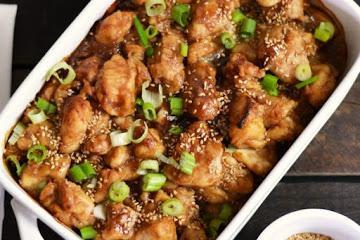

.......................................................................


RESULT 1 (33.05 distance)
s/roasted chicken w sticky rice


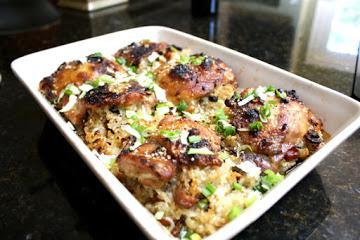

.......................................................................


RESULT 2 (34.3 distance)
s/sesame oil chicken


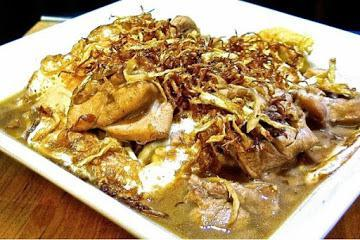

......................................................................


RESULT 3 (34.93 distance)
s/chicken in brown gravy over rice


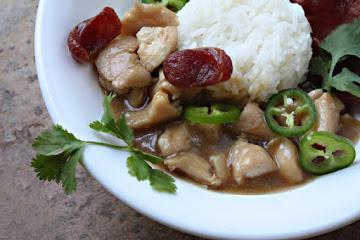

.......................................................................


RESULT 4 (35.14 distance)
s/paleo chinese salt and pepper chicken


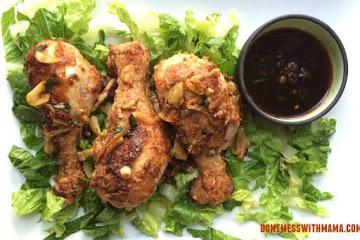

.......................................................................




In [24]:
print_nearest_neighbors(data, "text_embedding", query_2, get_caption_embedding(query_2), n=5)

## Step 5: Deliberately stress test the representation

Discover failure cases by intentionally testing situations where you believe the system should not work well.

### Plan
Have Copilot create a plan to:
- ensure search results are returned alongside their similarity scores or distance measures,
- reuse the existing embedding and search pipeline,
- run the system on a small set of **student-chosen test inputs** that you believe should produce poor, ambiguous, or misleading results.

You are responsible for selecting the test inputs. These should include:
- at least two inputs that you believe *should not* have meaningful matches in the dataset, and
- one input where similarity could reasonably be interpreted in multiple ways.

### Validate
Use Copilot to confirm that the plan:
- does not change the embedding model, index, or similarity metric,
- surfaces raw similarity scores for inspection,
- treats all inputs uniformly, without filtering or special handling.

Revise the plan until it reflects a straightforward reuse of the existing system.

### Execute
Once the plan is validated, have Copilot implement any minimal code changes needed (e.g., printing similarity scores, exposing distances, or reusing embedding functions).

Then run the system on your selected test inputs.

### Check
- For each test input, inspect the returned results and their similarity scores.
- Note whether the system returns results confidently even when the input is inappropriate or ill-defined.
- Identify at least one case where the numerical similarity does not align with what you would expect a user to find meaningful.

### Food for thought
- Are these failures obvious to a user, or would they appear plausible at first glance?
- Does the system ever recognize when there are no good results for a search?

In [25]:
# write Step 5 code below

inappropriate_query = "I need to find a dry cleaner that can remove ink stains from wool shirt"

ambiguous_query = "snacks"

Initial target: text
"I need to find a dry cleaner that can remove ink stains from wool shirt"
---------------------------------------------------------------

RESULT 0 (52.11 distance)
s/dryfried chicken


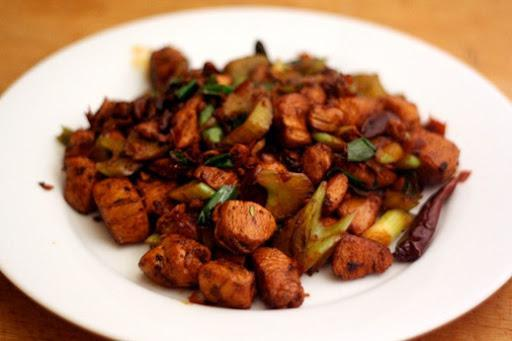

.......................................................................


RESULT 1 (52.81 distance)
s/wonton soup without ginger


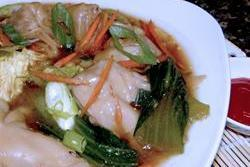

.......................................................................


RESULT 2 (53.39 distance)
s/sweet and sour dipping sauce


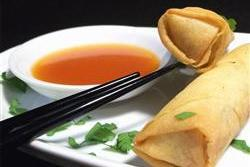

.......................................................................


RESULT 3 (54.13 distance)
s/the only dumpling recipe youl ever need


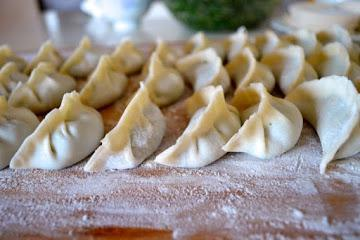

.......................................................................


RESULT 4 (54.4 distance)
s/chinese walnut chicken


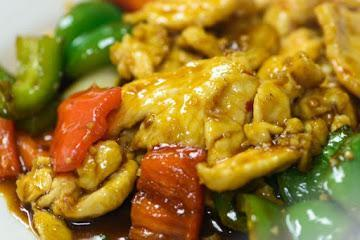

......................................................................




In [26]:
# check Step 5 code below

print_nearest_neighbors(data, "text_embedding", inappropriate_query, get_caption_embedding(inappropriate_query), n=5)

Initial target: text
"snacks"
---------------------------------------------------------------

RESULT 0 (40.2 distance)
s/sweet and sour sauce


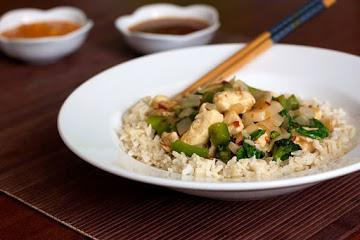

......................................................................


RESULT 1 (40.22 distance)
s/stir fry


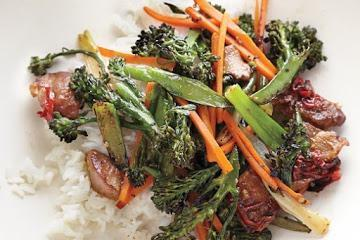

.......................................................................


RESULT 2 (40.37 distance)
s/exotic fruit salad


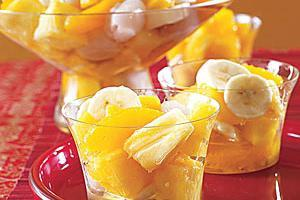

.......................................................................


RESULT 3 (41.46 distance)
s/chinese dumplings


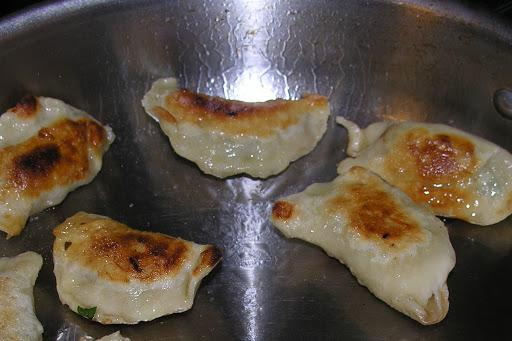

.......................................................................


RESULT 4 (41.68 distance)
s/pork and chestnuts


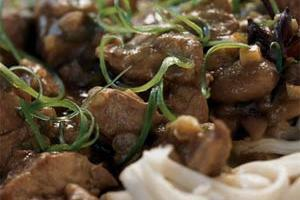

.......................................................................




In [27]:
print_nearest_neighbors(data, "text_embedding", ambiguous_query, get_caption_embedding(ambiguous_query), n=5)

## End of Act 2

At this point, you should have concrete evidence of how encoder-based representations behave, what kinds of similarity they induce, and where those similarities break down.

Before moving on to Act III, create a file named `README.md` in the project root.

This README should capture the current state of the prototype as if you were handing it off to a colleague. Keep it concise and grounded in what actually exists.

### 1. What this prototype does
In one sentence, clearly describe the capability that was built and the problem it is intended to address.

### 2. How it works (at a high level)
In a few bullet points, specify:
- what data the system operates over,
- what representation or model it uses,
- how results are produced.

### 3. Limitations and open questions
Briefly note:
- the most important limitations you observed or conceive of, and
- any open questions that would need to be addressed before broader use.


This README will be used as reference context in Act 3.

## Act 3 — Socialize the Work

You have built a working prototype. Now you need to think about what it would mean to use it.

In this act, you will have conversations with three "colleagues" who approach this feature from different professional perspectives:

- A **Product Manager** responsible for the digital ordering experience, focused on how customers interpret search results and whether the system builds or erodes trust in the menu.

- A **Menu and Merchandising Lead** focused on how image- and description-based search reshapes visibility across menu items, including bestsellers, new offerings, and less frequently ordered dishes.

- A **Restaurant Operations Manager** focused on what happens when the system returns ambiguous or misleading results and how that affects order accuracy, staff workload, and customer complaints.


Each of these perspectives highlights a different set of circumstantial concerns that emerge once a technical capability is placed inside an organization and exposed to real use.

Your goal in these conversations is to engage with those concerns. This means:
- explaining how the prototype behaves and performs,
- articulating tradeoffs in plain, cross-functional language,
- and reckoning with how technical choices intersect with human expectations, organizational processes, and downstream impact.

Each conversation should feel like a real internal discussion. When a persona has what they need to understand your reasoning and its implications, the conversation will naturally come to a close.


## End of Act 3

At this point, we're done! 